# Introduction

## Prêt à mener la mission ?

Vous êtes consultant pour <a href="https://olist.com/">Olist</a>, une entreprise brésilienne qui propose une solution de vente sur les marketplaces en ligne.


Votre rôle est d’accompagner Olist dans leur projet de monter une équipe Data et leur premier cas d’usage Data Science autour de la segmentation client.


Vous venez de rejoindre Olist dans un contexte de recrutement intensif afin de monter leur équipe Data. En effet, ils font d’abord appel à des consultants comme vous en renfort sur les sujets les plus critiques en attendant d'internaliser les compétences. Avant de réaliser la segmentation client, on vous attribue une première mission pour aider Fernanda, Lead Data Analyst chez Olist. 


Après avoir étudié les éléments partagés par Fernanda vous vous mettez au travail.


------------------------

## Quelques jours plus tard
 

Cette urgence résolue, vous pouvez enfin passer à votre mission principale : Olist souhaite que vous fournissiez à ses équipes d'e-commerce une **segmentation des clients** qu’elles pourront utiliser au quotidien pour leurs campagnes de communication.


Votre objectif est de comprendre les différents types d’utilisateurs grâce à leur comportement et à leurs données personnelles.
 

Vous devrez fournir à l’équipe Marketing **une description actionable** de votre segmentation et de sa logique sous-jacente pour une utilisation optimale, ainsi qu’une proposition de contrat de maintenance basée sur une analyse de la stabilité des segments au cours du temps.


**<u>Les données</u>**

Pour cette mission, Olist vous fournit une <a href="https://course.oc-static.com/projects/olist.db">base de données</a> anonymisée comportant des informations sur l’historique des commandes, les produits achetés, les commentaires de satisfaction, et la localisation des clients depuis janvier 2017.
 

Vous devez aider les équipes d’Olist à comprendre les différents types d'utilisateurs. Vous utiliserez donc des méthodes non supervisées pour regrouper des clients de profils similaires. Ces catégories pourront être utilisées par l’équipe Marketing pour mieux communiquer.
 

Vous créez donc un notebook et démarrez votre travail d’analyse exploratoire.


------------------------
 
## 3 jours plus tard
 

Après quelques premières analyses, vous vous rendez compte qu'Olist ne vous a pas fourni beaucoup de données ; vous enquêtez donc auprès de l'entreprise pour obtenir quelques informations complémentaires, et vérifier que vous avez bien compris la mission.


Vous réalisez trois autres documents afin de préparer une réponse à Olist : 

- Un notebook avec des essais des différentes approches de modélisation 
- Un notebook de simulation pour déterminer la fréquence nécessaire de mise à jour du modèle de segmentation, afin que celui-ci reste pertinent 
- Une présentation pour un collègue afin d’obtenir ses retours sur votre approche
 

C’est parti pour cette dernière ligne droite ! 

# Import des librairies

In [18]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import missingno as msno
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

## Chargement de seaborn

In [4]:
sns.set()

# Lecture du dataset

In [2]:
df = pd.read_csv("data_cleaned.csv")

# Ségmentation RFM

Afin d'appliquer la méthode RFM sur notre set de clients, nous allons calculer, pour chaque composante (récence, fréquence, montant), un score compris entre 1 et 4, en compartimentant nos données, à l'aide de la méthode des quartiles.

<a href="https://www.cartelis.com/blog/segmentation-rfm-definition-calcul/">Source des calculs effectués</a>

In [4]:
rfm_features = ["days_since_last_order", "total_orders", "total_value"]
rfm = df[rfm_features].copy()

## Score de récence

Tout d'abord, visualisons les séparations de nos compartiments :

In [5]:
df["days_since_last_order"].quantile([0.25, 0.5, 0.75])

0.25    113.0
0.50    218.0
0.75    345.0
Name: days_since_last_order, dtype: float64

Les compartiments sont cohérents, calculons le score de récence

In [6]:
rfm["Score R"] = pd.qcut(x=df["days_since_last_order"], q=4, labels=[4, 3, 2, 1]).astype(int)

Visualisons notre répartition

In [7]:
rfm["Score R"].value_counts()

Score R
3    23451
4    23396
1    23311
2    23200
Name: count, dtype: int64

## Score de fréquence

Tout d'abord, visualisons les séparations de nos compartiments :

In [8]:
df["total_orders"].quantile([0.25, 0.5, 0.75])

0.25    1.0
0.50    1.0
0.75    1.0
Name: total_orders, dtype: float64

Les quantiles de fréquence ne sont pas représentatifs, aussi adoptons une autre manière de compartimenter en procédant ainsi :
- un premier pour compartiment pour les clients ayant effectués 1 achat,
- un deuxième compartiment pour les clients ayant effectués 2 achats,
- un troisème compartiment pour les clients ayant effectués entre 2 et 5 achats,
- un dernier compartiment pour les clients ayant effectués plus de 5 achats.

In [9]:
# Create an pd.IntervalIndex object to categorize the number of orders
bins = pd.IntervalIndex.from_tuples([(0, 1), (1, 2), (2, 5), (5, 100)])
# Use the pd.cut to compartmentalize the customers
# Note : as the pd.cut returns a CategoricalDtype, we use .cat.codes to convert the categories to integer and add 1 
rfm["Score F"] = pd.cut(x=df["total_orders"], bins=bins).cat.codes + 1

Visualisons notre répartition

In [10]:
rfm["Score F"].value_counts()

Score F
1    90557
2     2573
3      218
4       10
Name: count, dtype: int64

## Score de montant

Tout d'abord, visualisons les séparations de nos compartiments :

In [11]:
df["total_value"].quantile([0.25, 0.5, 0.75])

0.25     61.32
0.50    106.10
0.75    180.04
Name: total_value, dtype: float64

Les compartiments sont cohérents, calculons le score de récence

In [12]:
rfm.loc[:, "Score M"] = pd.qcut(x=df["total_value"], q=4, labels=[1, 2, 3, 4]).astype(int)

Visualisons notre répartition

In [13]:
rfm["Score M"].value_counts()

Score M
1    23341
2    23341
4    23339
3    23337
Name: count, dtype: int64

## Catégorisation des clients

Afin de représenter la catégorisation de nos clients, nous allons définir des segments selon les scores de récence, fréquence et montant comme suit :

| **Segment**                  | **Récence (R)** | **Fréquence (F)** | **Montant (M)** | **Description**                                         |
|------------------------------|-----------------|-------------------|----------------|------------------------------------------------------|
| **Champions**                | 4               | 2 à 4            | ≥3             | Clients très récents, actifs et avec un montant élevé. |
| **Clients fidèles**          | 4               | 2 à 4            | 2 à 3          | Clients récents, plusieurs commandes, montant modéré.  |
| **Clients potentiels**       | 3 ou 4          | 1                | ≥1             | Nouveaux clients, faible fréquence mais potentiel d'achat. |
| **Clients en déclin**        | 2               | 1 à 2            | ≥1             | Moins récents, faible fréquence mais montant modéré à élevé. |
| **Clients perdus (faible dépense)** | 1 ou 2          | 1 à 2            | ≤2             | Clients peu récents, faible fréquence et faible montant. |
| **Clients perdus (montant élevé)**  | 1 ou 2          | 1 à 2            | >2             | Clients peu récents, faible fréquence mais montant élevé. |



Appliquons ensuite notre catégorisation

In [14]:
# Réinitialisation de la colonne "Catégorie client"
rfm["Catégorie client"] = "Autres"

# 1. Champions : Très récents, actifs, montant élevé
rfm.loc[(rfm["Score R"] == 4) & (rfm["Score F"].between(2, 4)) & (rfm["Score M"] >= 3), 
        "Catégorie client"] = "Champions"

# 2. Clients fidèles : Récents, plusieurs commandes, montant modéré
rfm.loc[(rfm["Score R"] == 4) & (rfm["Score F"].between(2, 4)) & (rfm["Score M"].between(2, 3)) & 
        (rfm["Catégorie client"] == "Autres"), "Catégorie client"] = "Clients fidèles"

# 3. Clients potentiels : Récents (R=3 ou 4), faible fréquence mais potentiel
rfm.loc[(rfm["Score R"].between(3, 4)) & (rfm["Score F"] == 1) & (rfm["Score M"] >= 1) & 
        (rfm["Catégorie client"] == "Autres"), "Catégorie client"] = "Clients potentiels"

# 4. Clients en déclin : Moins récents, faible fréquence mais montant modéré à élevé
rfm.loc[(rfm["Score R"] == 2) & (rfm["Score F"].between(1, 2)) & (rfm["Score M"] >= 1) & 
        (rfm["Catégorie client"] == "Autres"), "Catégorie client"] = "Clients en déclin"

# 5. Clients perdus (faible dépense) : Peu récents, faible fréquence et petit montant
rfm.loc[(rfm["Score R"].between(1, 2)) & (rfm["Score F"].between(1, 2)) & (rfm["Score M"] <= 2) & 
        (rfm["Catégorie client"] == "Autres"), "Catégorie client"] = "Clients perdus (faible dépense)"

# 6. Clients perdus (montant élevé) : Peu récents, faible fréquence mais montant élevé
rfm.loc[(rfm["Score R"].between(1, 2)) & (rfm["Score F"].between(1, 2)) & (rfm["Score M"] > 2) & 
        (rfm["Catégorie client"] == "Autres"), "Catégorie client"] = "Clients perdus (montant élevé)"

Affichons la répartition de nos catégories

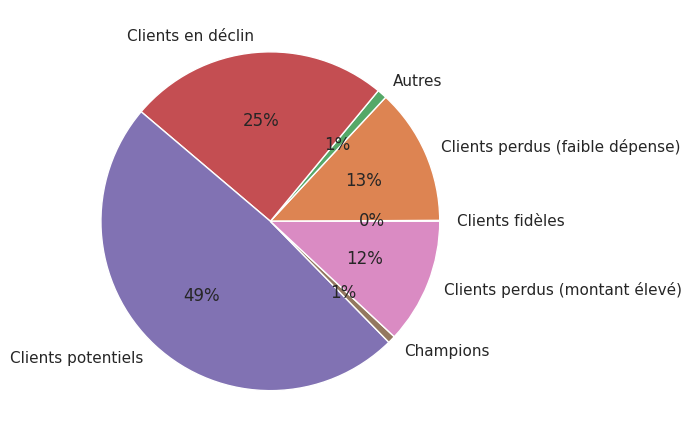

In [15]:
data = rfm["Catégorie client"].value_counts()*100 / rfm.shape[0]
# Mélange les lignes pour ne pas avoir les petites valeurs proches
data = data.sample(frac=1, random_state=5)
plt.pie(x=data, labels=data.index, autopct='%.0f%%')
plt.show()

# K-Means avec 3 variables

## Normalisation des données

In [16]:
rfm_features = ["days_since_last_order", "total_orders", "total_value"]
rfm_3var = df[rfm_features].copy()

Nous avons pu constaté lors de l'analyse exploratoire que les variables "total_orders" et "total_value" présentent un grand nombre d'outliers.

Aussi, nous allons leur appliquer une transformation logarithmique afin de diminuer le phénomène.

Dans un second temps nous centrerons et réduirons les données, à l'aide d'un StandardScaler.

### total_orders

Avant transformation

<Axes: xlabel='total_orders', ylabel='Density'>

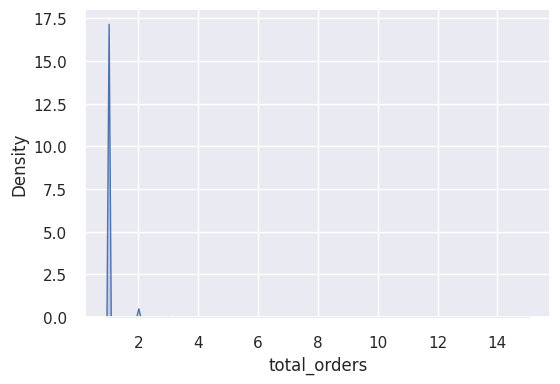

In [17]:
plt.figure(figsize=(6,4))
sns.kdeplot(data=rfm_3var["total_orders"], fill=True)

Après transformation

<Axes: xlabel='total_orders', ylabel='Density'>

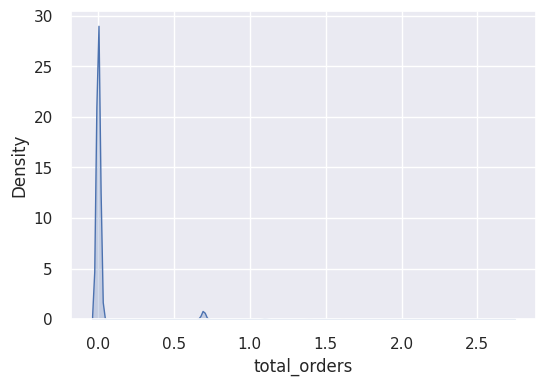

In [18]:
plt.figure(figsize=(6,4))
sns.kdeplot(data=np.log(rfm_3var["total_orders"]), fill=True)

On note moins d'outliers, nous validons donc l'application de cette transformation

In [19]:
rfm_3var["total_orders"] = np.log(rfm_3var["total_orders"])

### total_value

Avant transformation

<Axes: xlabel='total_value', ylabel='Density'>

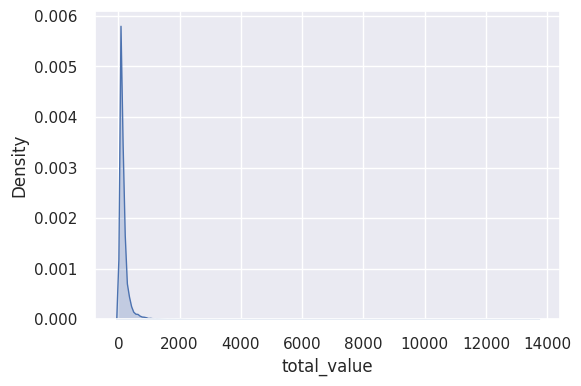

In [20]:
plt.figure(figsize=(6,4))
sns.kdeplot(data=rfm_3var["total_value"], fill=True)

Après transformation

<Axes: xlabel='total_value', ylabel='Density'>

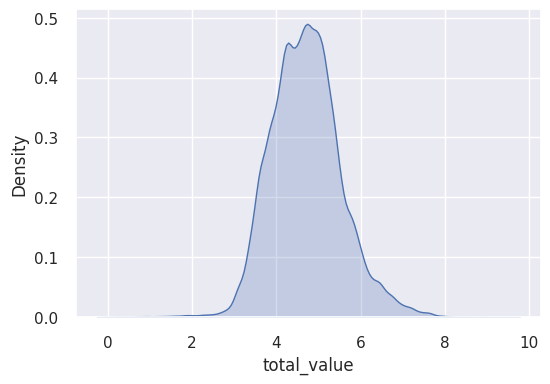

In [21]:
plt.figure(figsize=(6,4))
sns.kdeplot(data=np.log1p(rfm_3var["total_value"]), fill=True)

On note moins d'outliers, nous validons donc l'application de cette transformation

In [22]:
rfm_3var["total_value"] = np.log1p(rfm_3var["total_value"])

### Normalisation

Appliquons à présent le StandardScaler pour centrer-réduire les données

In [8]:
scaler = StandardScaler()
rfm_3var_scaled = scaler.fit_transform(rfm_3var)

NameError: name 'rfm_3var' is not defined

## Choix du nombre de clusters

Afin de sélectionner le bon nombre de clusters, nous allons appliquer la méthode du coude d'une part et la méthode de la silhouette d'autre part

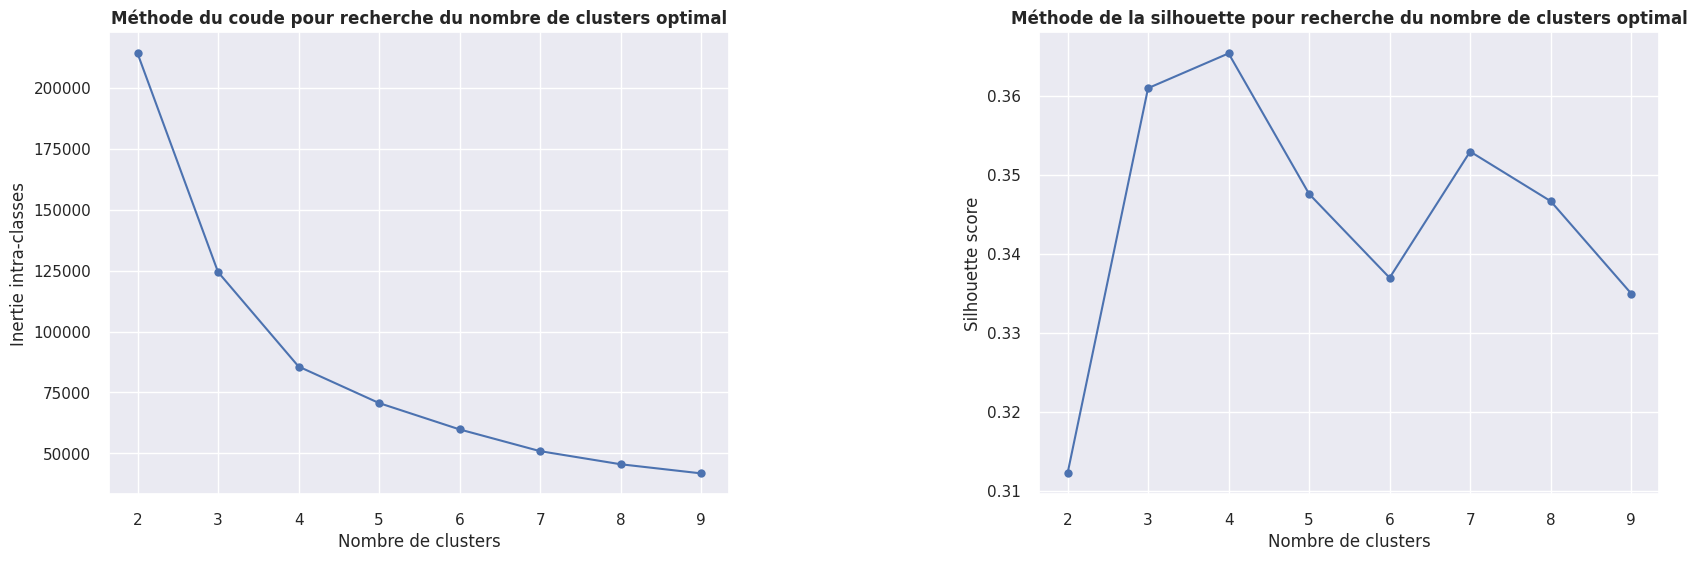

In [24]:
K = range(2,10)
inerties = []
silhouettes = []

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=8)
    kmeans.fit(rfm_3var_scaled)
    cluster_labels = kmeans.labels_
    
    inerties.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(rfm_3var_scaled, cluster_labels))


plt.figure(figsize = (20, 6))
grid = plt.GridSpec(1, 2, wspace=0.5, hspace=0.3)

plt.subplot(grid[0,0])
plt.plot(K, inerties, marker="o")
plt.xlabel("Nombre de clusters") 
plt.ylabel("Inertie intra-classes") 
plt.title("Méthode du coude pour recherche du nombre de clusters optimal", fontweight="bold")

plt.subplot(grid[0,1])
plt.plot(K, silhouettes, marker="o")
plt.xlabel("Nombre de clusters") 
plt.ylabel("Silhouette score") 
plt.title("Méthode de la silhouette pour recherche du nombre de clusters optimal", fontweight="bold")

plt.show()

Les deux méthodes préconisent entre 3 et 4 clusters, nous essayerons les deux pour les départager

## Clustering avec 3 et 4 clusters

Dans un premier temps visualisons les clusters produits sur un  graphique en deux dimensions avec :
- en X la récence
- en Y la moyenne de la fréquence et du montant

Text(0.5, 1.0, 'Représentation des clusters')

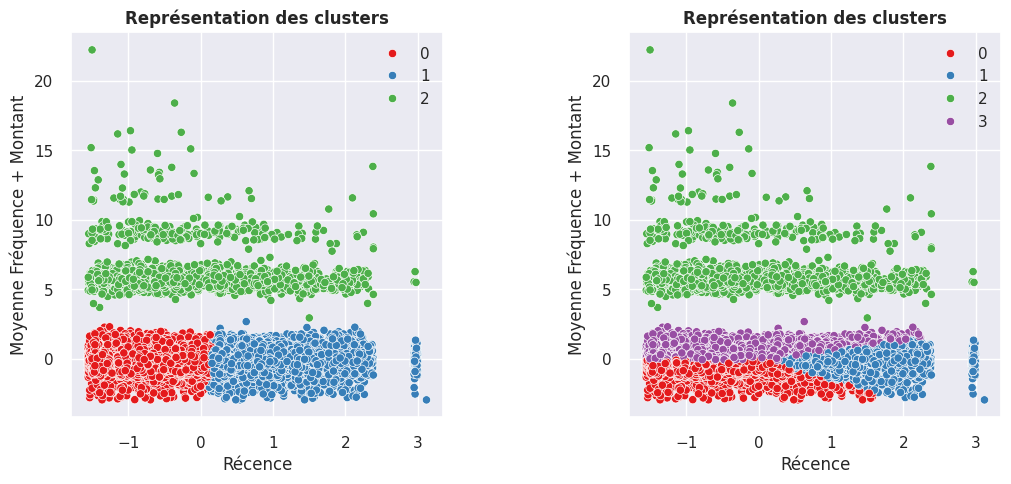

In [25]:
fig = plt.figure(figsize=(12,5))
grid = plt.GridSpec(1, 2, wspace=0.5, hspace=0.3)

kmeans_3var_3clus = KMeans(n_clusters=3, random_state=8)
kmeans_3var_3clus.fit(rfm_3var_scaled)
plt.subplot(grid[0,0])
sns.scatterplot(x=rfm_3var_scaled[:, 0], y=(rfm_3var_scaled[:, 1]+rfm_3var_scaled[:, 2] / 2), 
                hue=kmeans_3var_3clus.labels_, palette="Set1")
plt.xlabel("Récence")
plt.ylabel("Moyenne Fréquence + Montant")
plt.title("Représentation des clusters", fontweight="bold")

kmeans_3var_4clus = KMeans(n_clusters=4, random_state=8)
kmeans_3var_4clus.fit(rfm_3var_scaled)
plt.subplot(grid[0,1])
sns.scatterplot(x=rfm_3var_scaled[:, 0], y=(rfm_3var_scaled[:, 1]+rfm_3var_scaled[:, 2] / 2), 
                hue=kmeans_3var_4clus.labels_, palette="Set1")
plt.xlabel("Récence")
plt.ylabel("Moyenne Fréquence + Montant")
plt.title("Représentation des clusters", fontweight="bold")

Ensuite, nous visualisons les silhouettes des deux clusterings

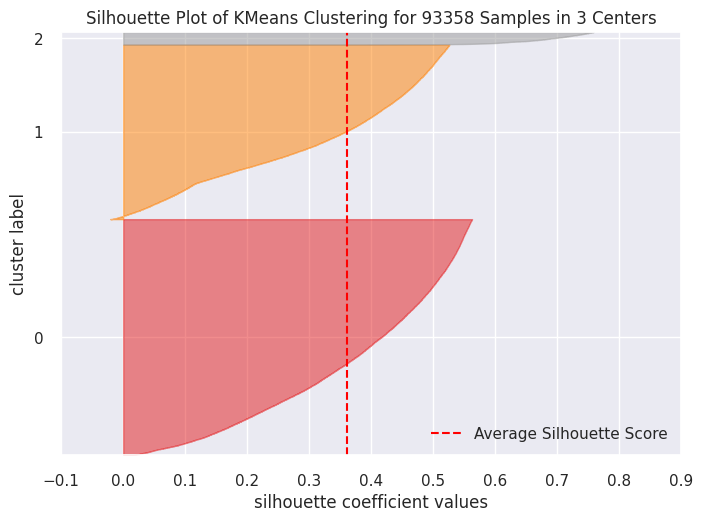

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 93358 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [26]:
# Instantiate the clustering model and visualizer 
visualizer = SilhouetteVisualizer(kmeans_3var_3clus)

visualizer.fit(rfm_3var_scaled)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the dat

Avec 3 clusters, on remarque que les clusters ne sont pas homogènes, dont notamment un avec un score de silhouette très élévé.

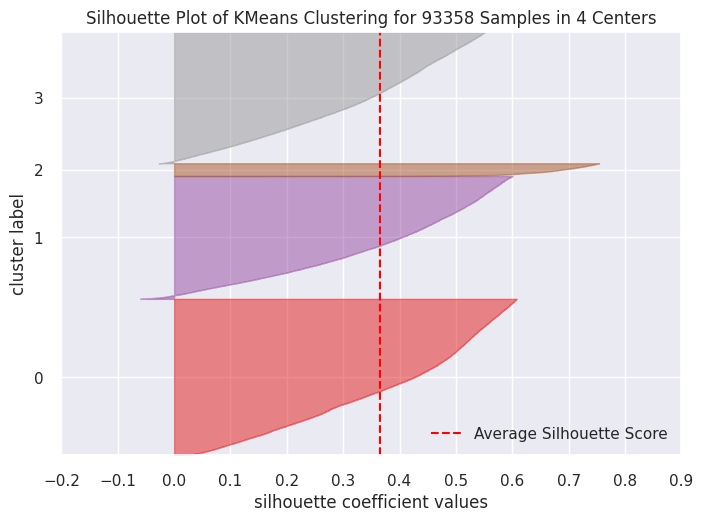

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 93358 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [27]:
# Instantiate the clustering model and visualizer 
visualizer = SilhouetteVisualizer(kmeans_3var_4clus)

visualizer.fit(rfm_3var_scaled)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the dat

Avec 4 clusters, ceux-ci sont plus homogènes avec tout de même un petit cluster avec un score de silhouette très élévé.

On remarque tout de même que les scores de silhouettes sont légèrement meilleurs que sur la clusterisation avec 3 compartiments.

La répartition avec 4 clusters semble plus pertinente.

## Analyse métier des clusters

Ajoutons les labels à notre dataframe d'origine

In [28]:
# Initialize dataframe without scaled values
rfm_3var = df[rfm_features].copy()
rfm_3var["Clusters"] = kmeans_3var_4clus.labels_

,days_since_last_order,total_orders,total_value,Clusters
0,111,1,141.90,3
1,114,1,27.19,0
2,536,1,86.22,1
3,320,1,43.62,1
4,287,1,196.89,3
...,...,...,...,...
93353,446,1,2067.42,3
93354,261,1,84.58,0
93355,567,1,112.46,1
93356,118,1,133.69,3


Afin d'expliquer nos différents compartiments, calculons les statistiques de nos différents clusters.

Pour cela regroupons nos clusters en 4 dataframes distincts.

In [29]:
cluster_1 = rfm_3var.loc[rfm_3var["Clusters"]==0,:]
cluster_2 = rfm_3var.loc[rfm_3var["Clusters"]==1,:]
cluster_3 = rfm_3var.loc[rfm_3var["Clusters"]==2,:]
cluster_4 = rfm_3var.loc[rfm_3var["Clusters"]==3,:]

Affichons à présent les distributions de nos valeurs pour chacun des clusters

/tmp/ipykernel_923464/1215692218.py:41: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=cluster_1["total_orders"], fill=True)
/tmp/ipykernel_923464/1215692218.py:49: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=cluster_2["total_orders"], fill=True)
/tmp/ipykernel_923464/1215692218.py:65: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=cluster_4["total_orders"], fill=True)


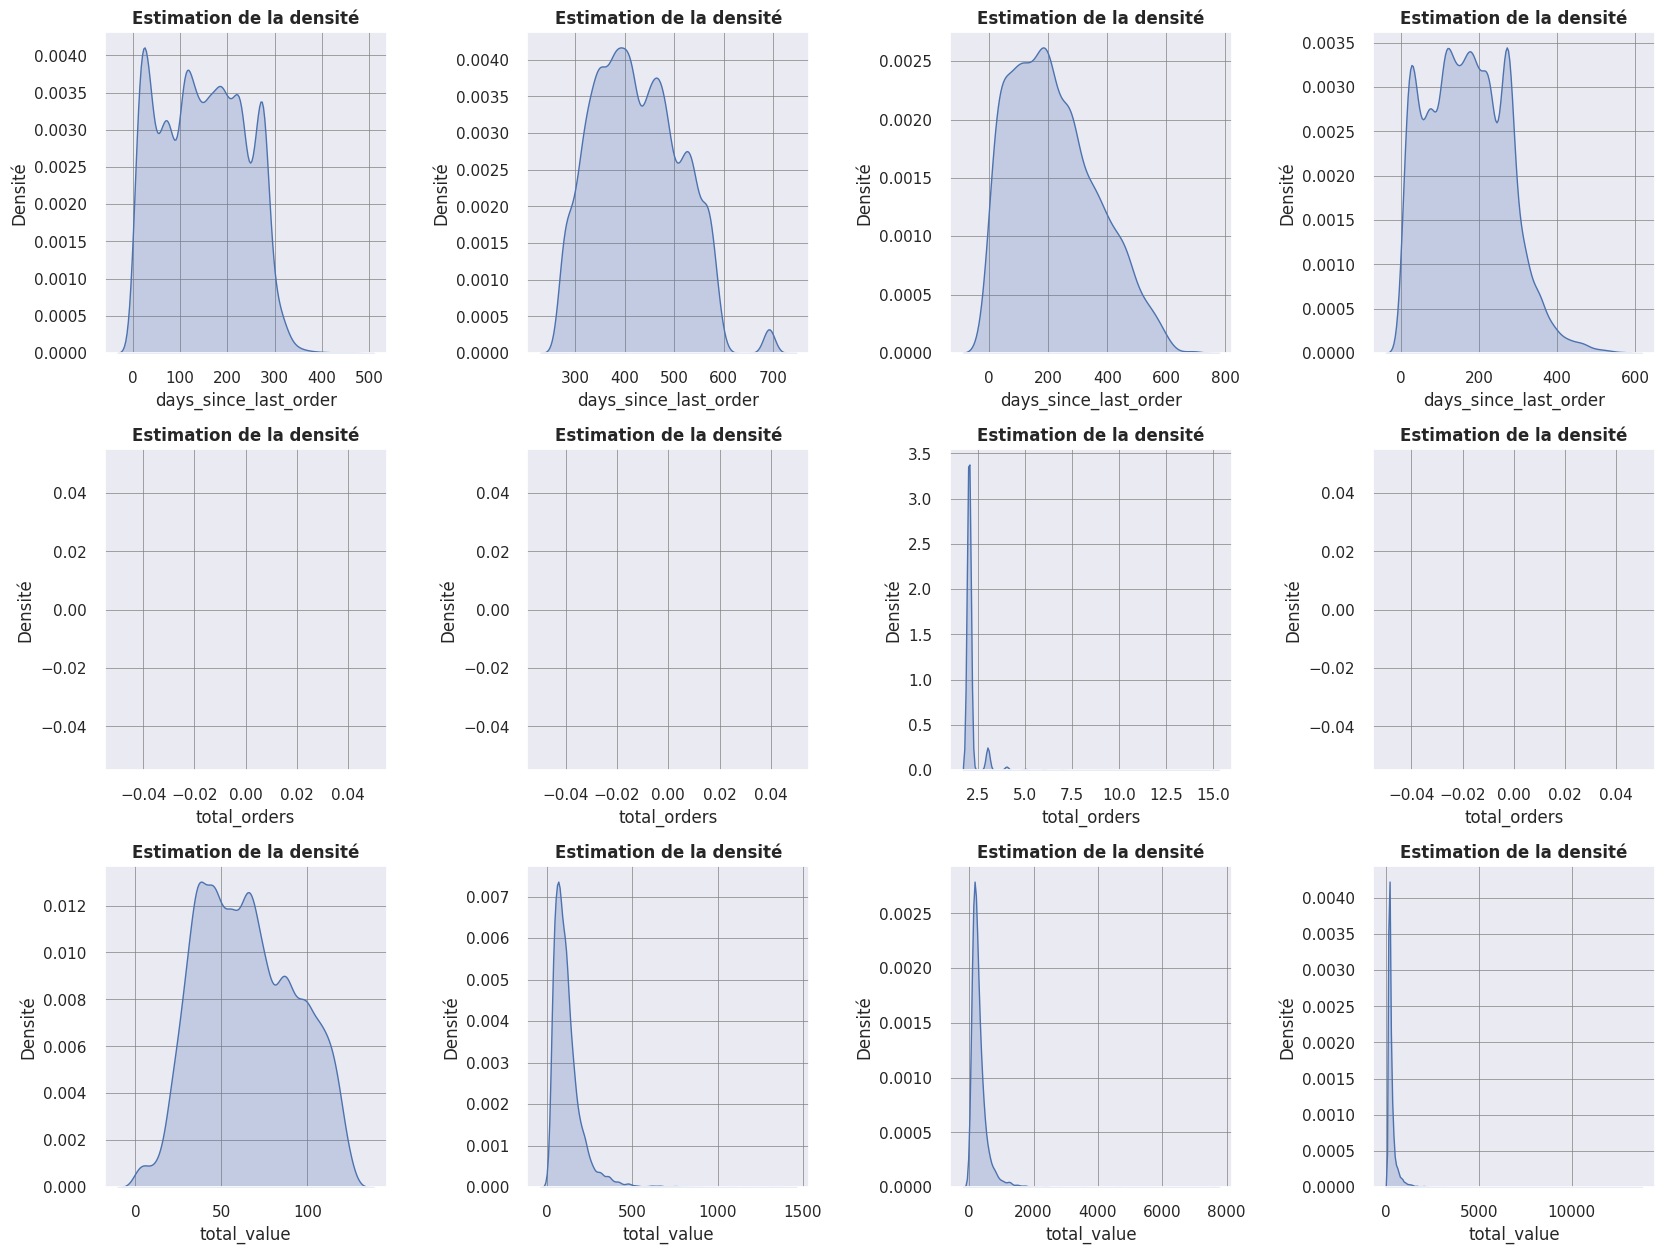

In [30]:
# Configure the grid for plots
plt.figure(figsize = (20, 15))
grid = plt.GridSpec(3, 4, wspace=0.5, hspace=0.3)

# days_since_last_order
# Density estimation cluster 1 
plt.subplot(grid[0,0])
sns.kdeplot(data=cluster_1["days_since_last_order"], fill=True)
plt.title("Estimation de la densité", fontweight="bold")
plt.xlabel("days_since_last_order")
plt.ylabel("Densité")
plt.grid(color="gray", linestyle="-", linewidth=0.5)
    
# Density estimation cluster 2 
plt.subplot(grid[0,1])
sns.kdeplot(data=cluster_2["days_since_last_order"], fill=True)
plt.title("Estimation de la densité", fontweight="bold")
plt.xlabel("days_since_last_order")
plt.ylabel("Densité")
plt.grid(color="gray", linestyle="-", linewidth=0.5)
    
# Density estimation cluster 3 
plt.subplot(grid[0,2])
sns.kdeplot(data=cluster_3["days_since_last_order"], fill=True)
plt.title("Estimation de la densité", fontweight="bold")
plt.xlabel("days_since_last_order")
plt.ylabel("Densité")
plt.grid(color="gray", linestyle="-", linewidth=0.5)

# Density estimation cluster 4 
plt.subplot(grid[0,3])
sns.kdeplot(data=cluster_4["days_since_last_order"], fill=True)
plt.title("Estimation de la densité", fontweight="bold")
plt.xlabel("days_since_last_order")
plt.ylabel("Densité")
plt.grid(color="gray", linestyle="-", linewidth=0.5)

# total_orders
# Density estimation cluster 1 
plt.subplot(grid[1,0])
sns.kdeplot(data=cluster_1["total_orders"], fill=True)
plt.title("Estimation de la densité", fontweight="bold")
plt.xlabel("total_orders")
plt.ylabel("Densité")
plt.grid(color="gray", linestyle="-", linewidth=0.5)
    
# Density estimation cluster 2 
plt.subplot(grid[1,1])
sns.kdeplot(data=cluster_2["total_orders"], fill=True)
plt.title("Estimation de la densité", fontweight="bold")
plt.xlabel("total_orders")
plt.ylabel("Densité")
plt.grid(color="gray", linestyle="-", linewidth=0.5)
    
# Density estimation cluster 3 
plt.subplot(grid[1,2])
sns.kdeplot(data=cluster_3["total_orders"], fill=True)
plt.title("Estimation de la densité", fontweight="bold")
plt.xlabel("total_orders")
plt.ylabel("Densité")
plt.grid(color="gray", linestyle="-", linewidth=0.5)

# Density estimation cluster 4 
plt.subplot(grid[1,3])
sns.kdeplot(data=cluster_4["total_orders"], fill=True)
plt.title("Estimation de la densité", fontweight="bold")
plt.xlabel("total_orders")
plt.ylabel("Densité")
plt.grid(color="gray", linestyle="-", linewidth=0.5)

# total_value
# Density estimation cluster 1 
plt.subplot(grid[2,0])
sns.kdeplot(data=cluster_1["total_value"], fill=True)
plt.title("Estimation de la densité", fontweight="bold")
plt.xlabel("total_value")
plt.ylabel("Densité")
plt.grid(color="gray", linestyle="-", linewidth=0.5)
    
# Density estimation cluster 2 
plt.subplot(grid[2,1])
sns.kdeplot(data=cluster_2["total_value"], fill=True)
plt.title("Estimation de la densité", fontweight="bold")
plt.xlabel("total_value")
plt.ylabel("Densité")
plt.grid(color="gray", linestyle="-", linewidth=0.5)
    
# Density estimation cluster 3 
plt.subplot(grid[2,2])
sns.kdeplot(data=cluster_3["total_value"], fill=True)
plt.title("Estimation de la densité", fontweight="bold")
plt.xlabel("total_value")
plt.ylabel("Densité")
plt.grid(color="gray", linestyle="-", linewidth=0.5)

# Density estimation cluster 4 
plt.subplot(grid[2,3])
sns.kdeplot(data=cluster_4["total_value"], fill=True)
plt.title("Estimation de la densité", fontweight="bold")
plt.xlabel("total_value")
plt.ylabel("Densité")
plt.grid(color="gray", linestyle="-", linewidth=0.5)

On constate tout d'abord, d'après les warnings reçus à l'exécution, que les clusters 1, 2 et 4 ont une variance de 0, ce qui signifie que tous les clients des ces clusters ont le même nombre de commandes, affichons le :

In [31]:
print(f"Nombre de commandes du cluster 1 : {cluster_1["total_orders"].mean()}")
print(f"Nombre de commandes du cluster 2 : {cluster_2["total_orders"].mean()}")
print(f"Nombre de commandes du cluster 4 : {cluster_4["total_orders"].mean()}")

Nombre de commandes du cluster 1 : 1.0
Nombre de commandes du cluster 2 : 1.0
Nombre de commandes du cluster 4 : 1.0


Ainsi, nous pouvons catégoriser nos clients comme suit :
- **Premier cluster** : clients moins récents, faible fréquence et montant => **clients en déclin**
- **Deuxième cluster** : clients peu récents avec une faible fréquence et un faible montant => **clients perdus**
- **Troisième cluster** : clients très récents, actifs, avec un montant élevé => **champions**
- **Quatrième cluster** : nouveaux clients avec une faible fréquence mais un potentiel d'achat => **clients potentiels**

# K-Means avec 4 variables

On ajoute le score de commentaire moyen du client

In [3]:
rfm_features = ["days_since_last_order", "total_orders", "total_value", "mean_review_score"]
rfm_4var = df[rfm_features].copy()

On vérifie sa distribution

<Axes: xlabel='mean_review_score', ylabel='Density'>

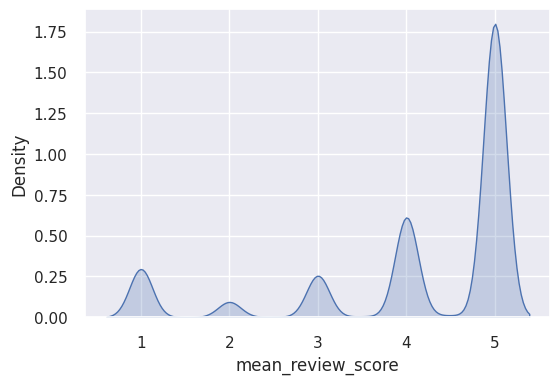

In [33]:
plt.figure(figsize=(6,4))
sns.kdeplot(data=rfm_4var["mean_review_score"], fill=True)

La distribution est satisfaisante, nous procédons ensuite à la normalisation avec le même scaler que précédemment

In [4]:
scaler = StandardScaler()
rfm_4var_scaled = scaler.fit_transform(rfm_4var)

## Choix du nombre de clusters

Afin de sélectionner le bon nombre de clusters, nous allons appliquer la méthode du coude d'une part et la méthode de la silhouette d'autre part

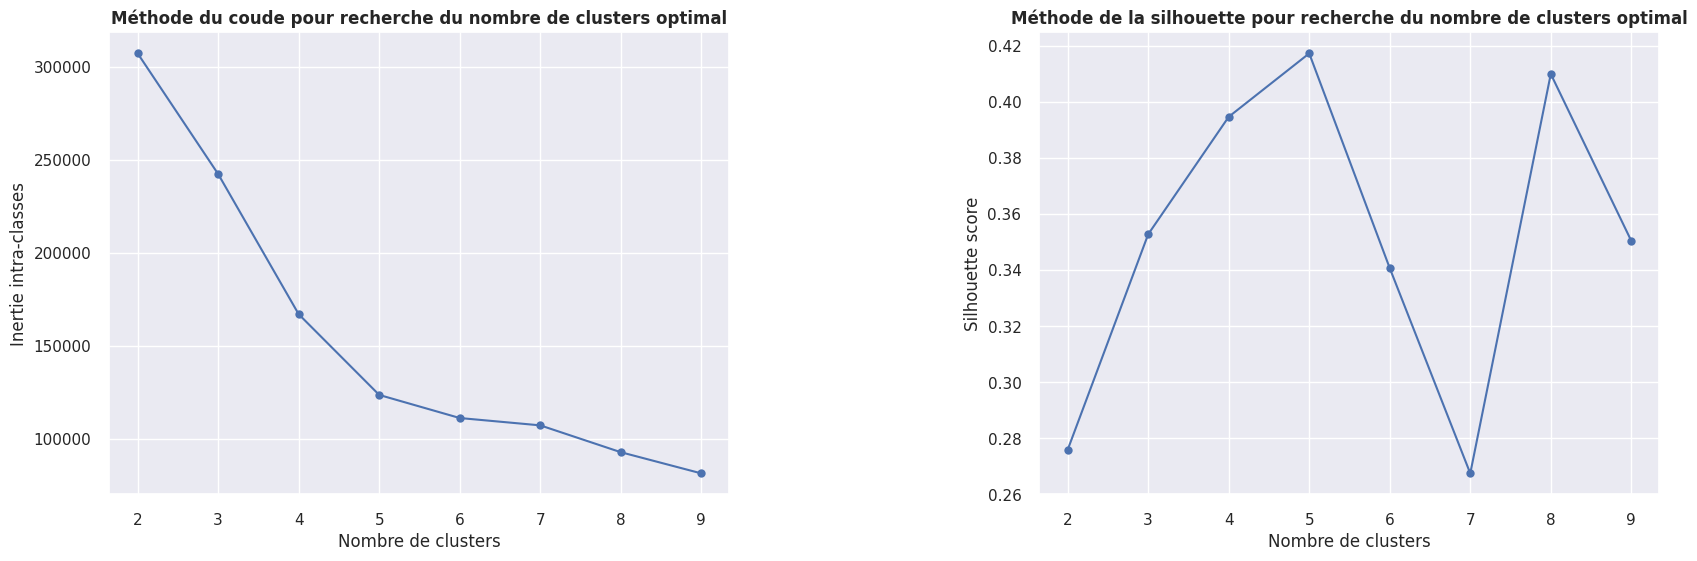

In [35]:
K = range(2,10)
inerties = []
silhouettes = []

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=8)
    kmeans.fit(rfm_4var_scaled)
    cluster_labels = kmeans.labels_
    
    inerties.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(rfm_4var_scaled, cluster_labels))


plt.figure(figsize = (20, 6))
grid = plt.GridSpec(1, 2, wspace=0.5, hspace=0.3)

plt.subplot(grid[0,0])
plt.plot(K, inerties, marker="o")
plt.xlabel("Nombre de clusters") 
plt.ylabel("Inertie intra-classes") 
plt.title("Méthode du coude pour recherche du nombre de clusters optimal", fontweight="bold")

plt.subplot(grid[0,1])
plt.plot(K, silhouettes, marker="o")
plt.xlabel("Nombre de clusters") 
plt.ylabel("Silhouette score") 
plt.title("Méthode de la silhouette pour recherche du nombre de clusters optimal", fontweight="bold")

plt.show()

La méthode du coude préconise 5 clusters, cependant la méthode de la silhouette montre un score intéressant avec 8 clusters.

Nous essayerons les deux valeurs pour les départager.

## Clustering avec 5 et 8 clusters

Dans un premier temps visualisons les clusters produits sur un  graphique en deux dimensions avec :
- en X la récence
- en Y la moyenne de la fréquence et du montant

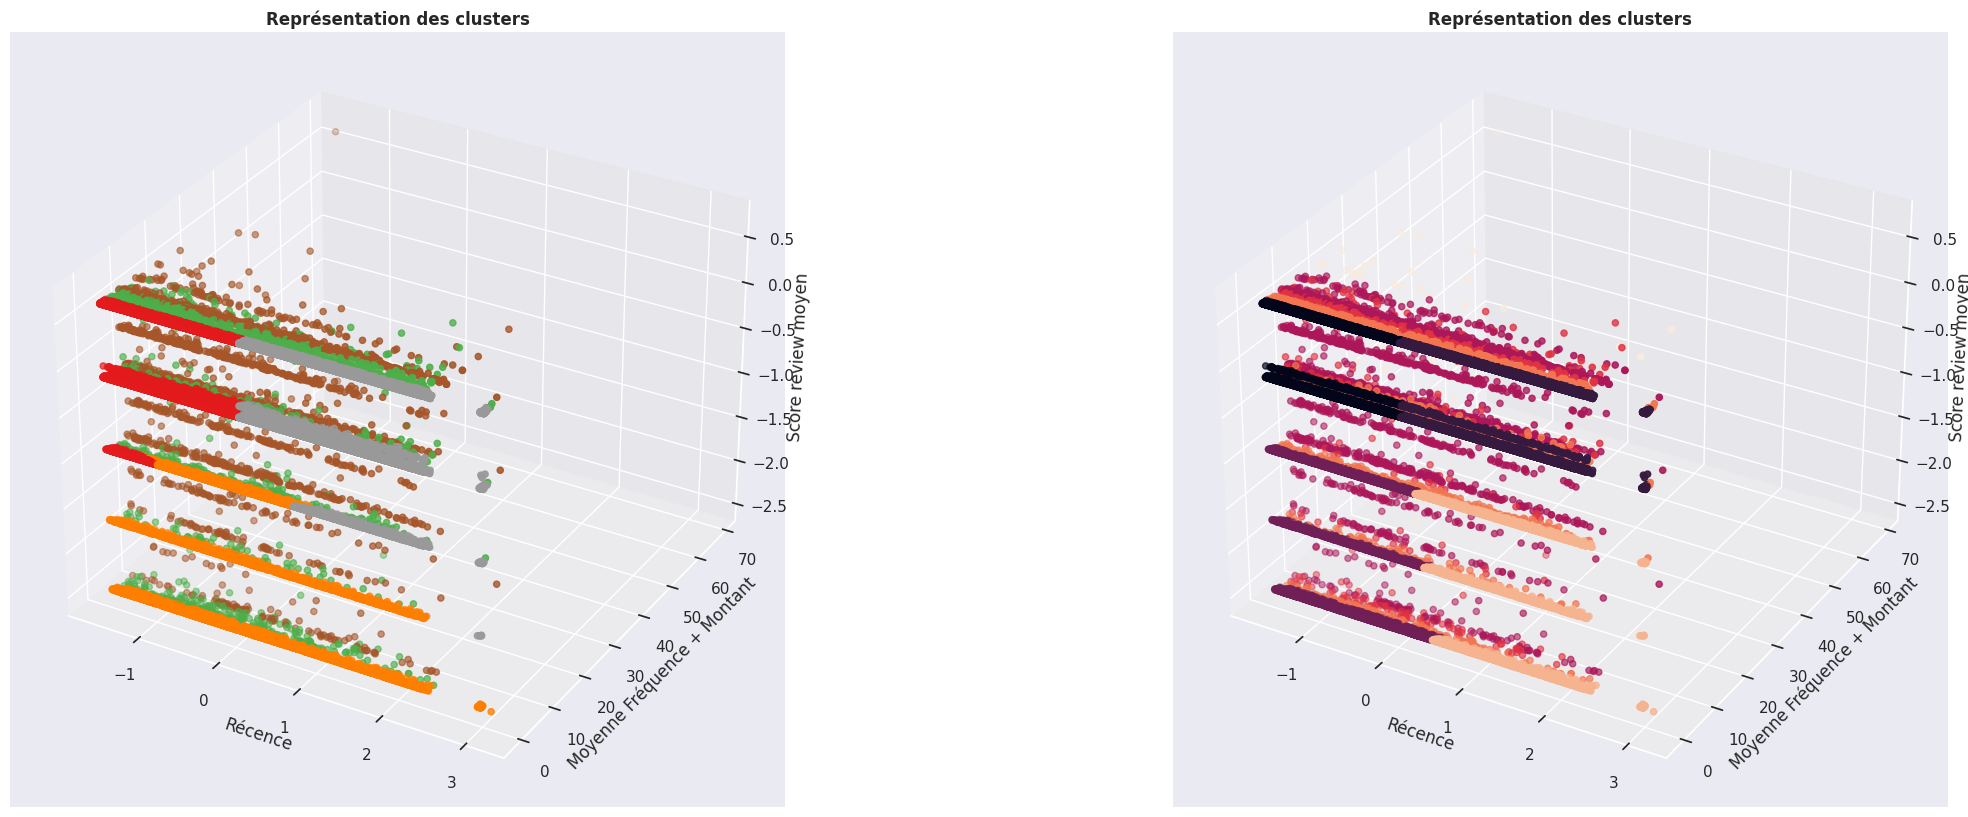

In [36]:
fig = plt.figure(figsize=(25,20))
grid = plt.GridSpec(1, 2, wspace=0.5, hspace=0.3)
sns.set_palette("Set1")

kmeans_4var_5clus = KMeans(n_clusters=5, random_state=8)
kmeans_4var_5clus.fit(rfm_4var_scaled)
ax1 = fig.add_subplot(grid[0,0], projection="3d")
#plt.subplot(grid[0,0])
ax1.scatter(xs=rfm_4var_scaled[:, 0], ys=rfm_4var_scaled[:, 1]+rfm_4var_scaled[:, 2] / 2, 
    zs=rfm_4var_scaled[:, 3], c=kmeans_4var_5clus.labels_, cmap="Set1")
ax1.set_xlabel("Récence")
ax1.set_ylabel("Moyenne Fréquence + Montant")
ax1.set_zlabel("Score review moyen")
plt.title("Représentation des clusters", fontweight="bold")

kmeans_4var_8clus = KMeans(n_clusters=8, random_state=8)
kmeans_4var_8clus.fit(rfm_4var_scaled)
ax2 = fig.add_subplot(grid[0,1], projection="3d")
ax2.scatter(rfm_4var_scaled[:, 0], rfm_4var_scaled[:, 1]+rfm_4var_scaled[:, 2] / 2, 
    rfm_4var_scaled[:, 3], c=kmeans_4var_8clus.labels_)
ax2.set_xlabel("Récence")
ax2.set_ylabel("Moyenne Fréquence + Montant")
ax2.set_zlabel("Score review moyen")
plt.title("Représentation des clusters", fontweight="bold")

plt.show()

Ensuite, nous visualisons les silhouettes des deux clusterings

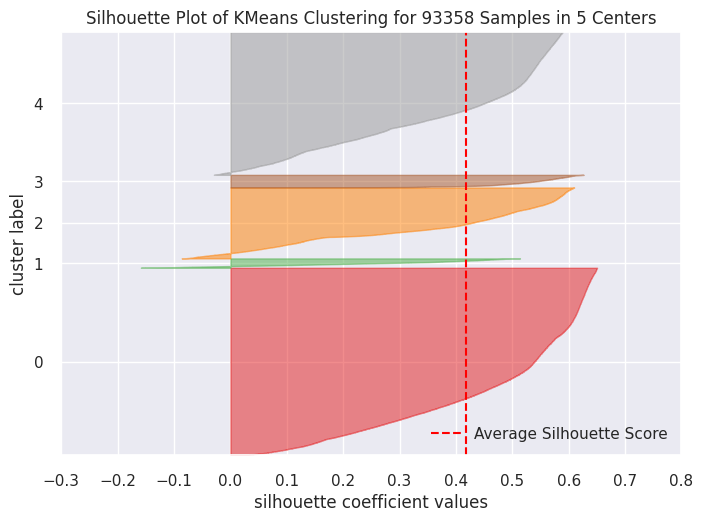

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 93358 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [37]:
# Instantiate the clustering model and visualizer 
visualizer = SilhouetteVisualizer(kmeans_4var_5clus)

visualizer.fit(rfm_4var_scaled)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the dat

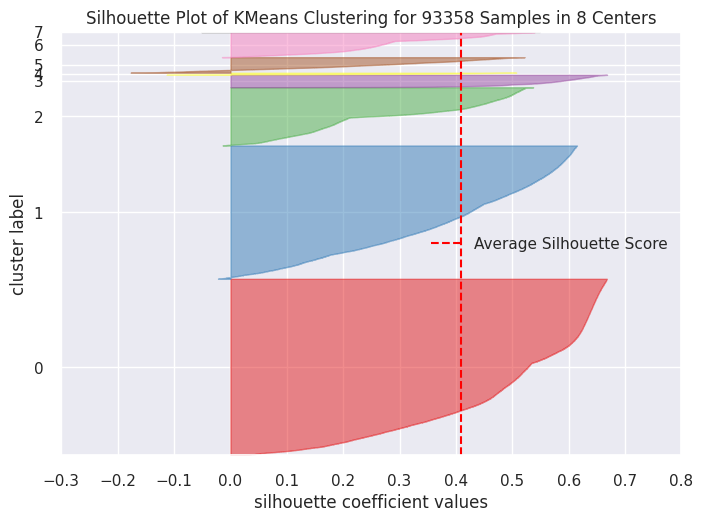

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 93358 Samples in 8 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [38]:
# Instantiate the clustering model and visualizer 
visualizer = SilhouetteVisualizer(kmeans_4var_8clus)

visualizer.fit(rfm_4var_scaled)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the dat

Les scores de silhouette et l'homogénéité sont meilleurs avec 5 clusters, nous poursuivrons l'analyse avec ce nombre de clusters

## Analyse métier des clusters

Ajoutons les labels à notre dataframe d'origine

In [39]:
# Initialize dataframe without scaled values
rfm_4var = df[rfm_features].copy()
rfm_4var["mean_review_score"] = df["mean_review_score"]
rfm_4var["Clusters"] = kmeans_4var_5clus.labels_
rfm_4var

,days_since_last_order,total_orders,total_value,mean_review_score,Clusters
0,111,1,141.90,5.0,0
1,114,1,27.19,4.0,0
2,536,1,86.22,3.0,4
3,320,1,43.62,4.0,4
4,287,1,196.89,5.0,4
...,...,...,...,...,...
93353,446,1,2067.42,5.0,1
93354,261,1,84.58,4.0,4
93355,567,1,112.46,5.0,4
93356,118,1,133.69,5.0,0


Afin d'expliquer nos différents compartiments, calculons les statistiques de nos différents clusters.

Pour cela regroupons nos clusters en 4 dataframes distincts.

In [40]:
cluster_1 = rfm_4var.loc[rfm_4var["Clusters"]==0,:]
cluster_2 = rfm_4var.loc[rfm_4var["Clusters"]==1,:]
cluster_3 = rfm_4var.loc[rfm_4var["Clusters"]==2,:]
cluster_4 = rfm_4var.loc[rfm_4var["Clusters"]==3,:]
cluster_5 = rfm_4var.loc[rfm_4var["Clusters"]==4,:]

Affichons à présent les distributions de nos valeurs pour chacun des clusters

/tmp/ipykernel_923464/3437202128.py:49: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=cluster_1["total_orders"], fill=True)
/tmp/ipykernel_923464/3437202128.py:65: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=cluster_3["total_orders"], fill=True)
/tmp/ipykernel_923464/3437202128.py:81: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=cluster_5["total_orders"], fill=True)


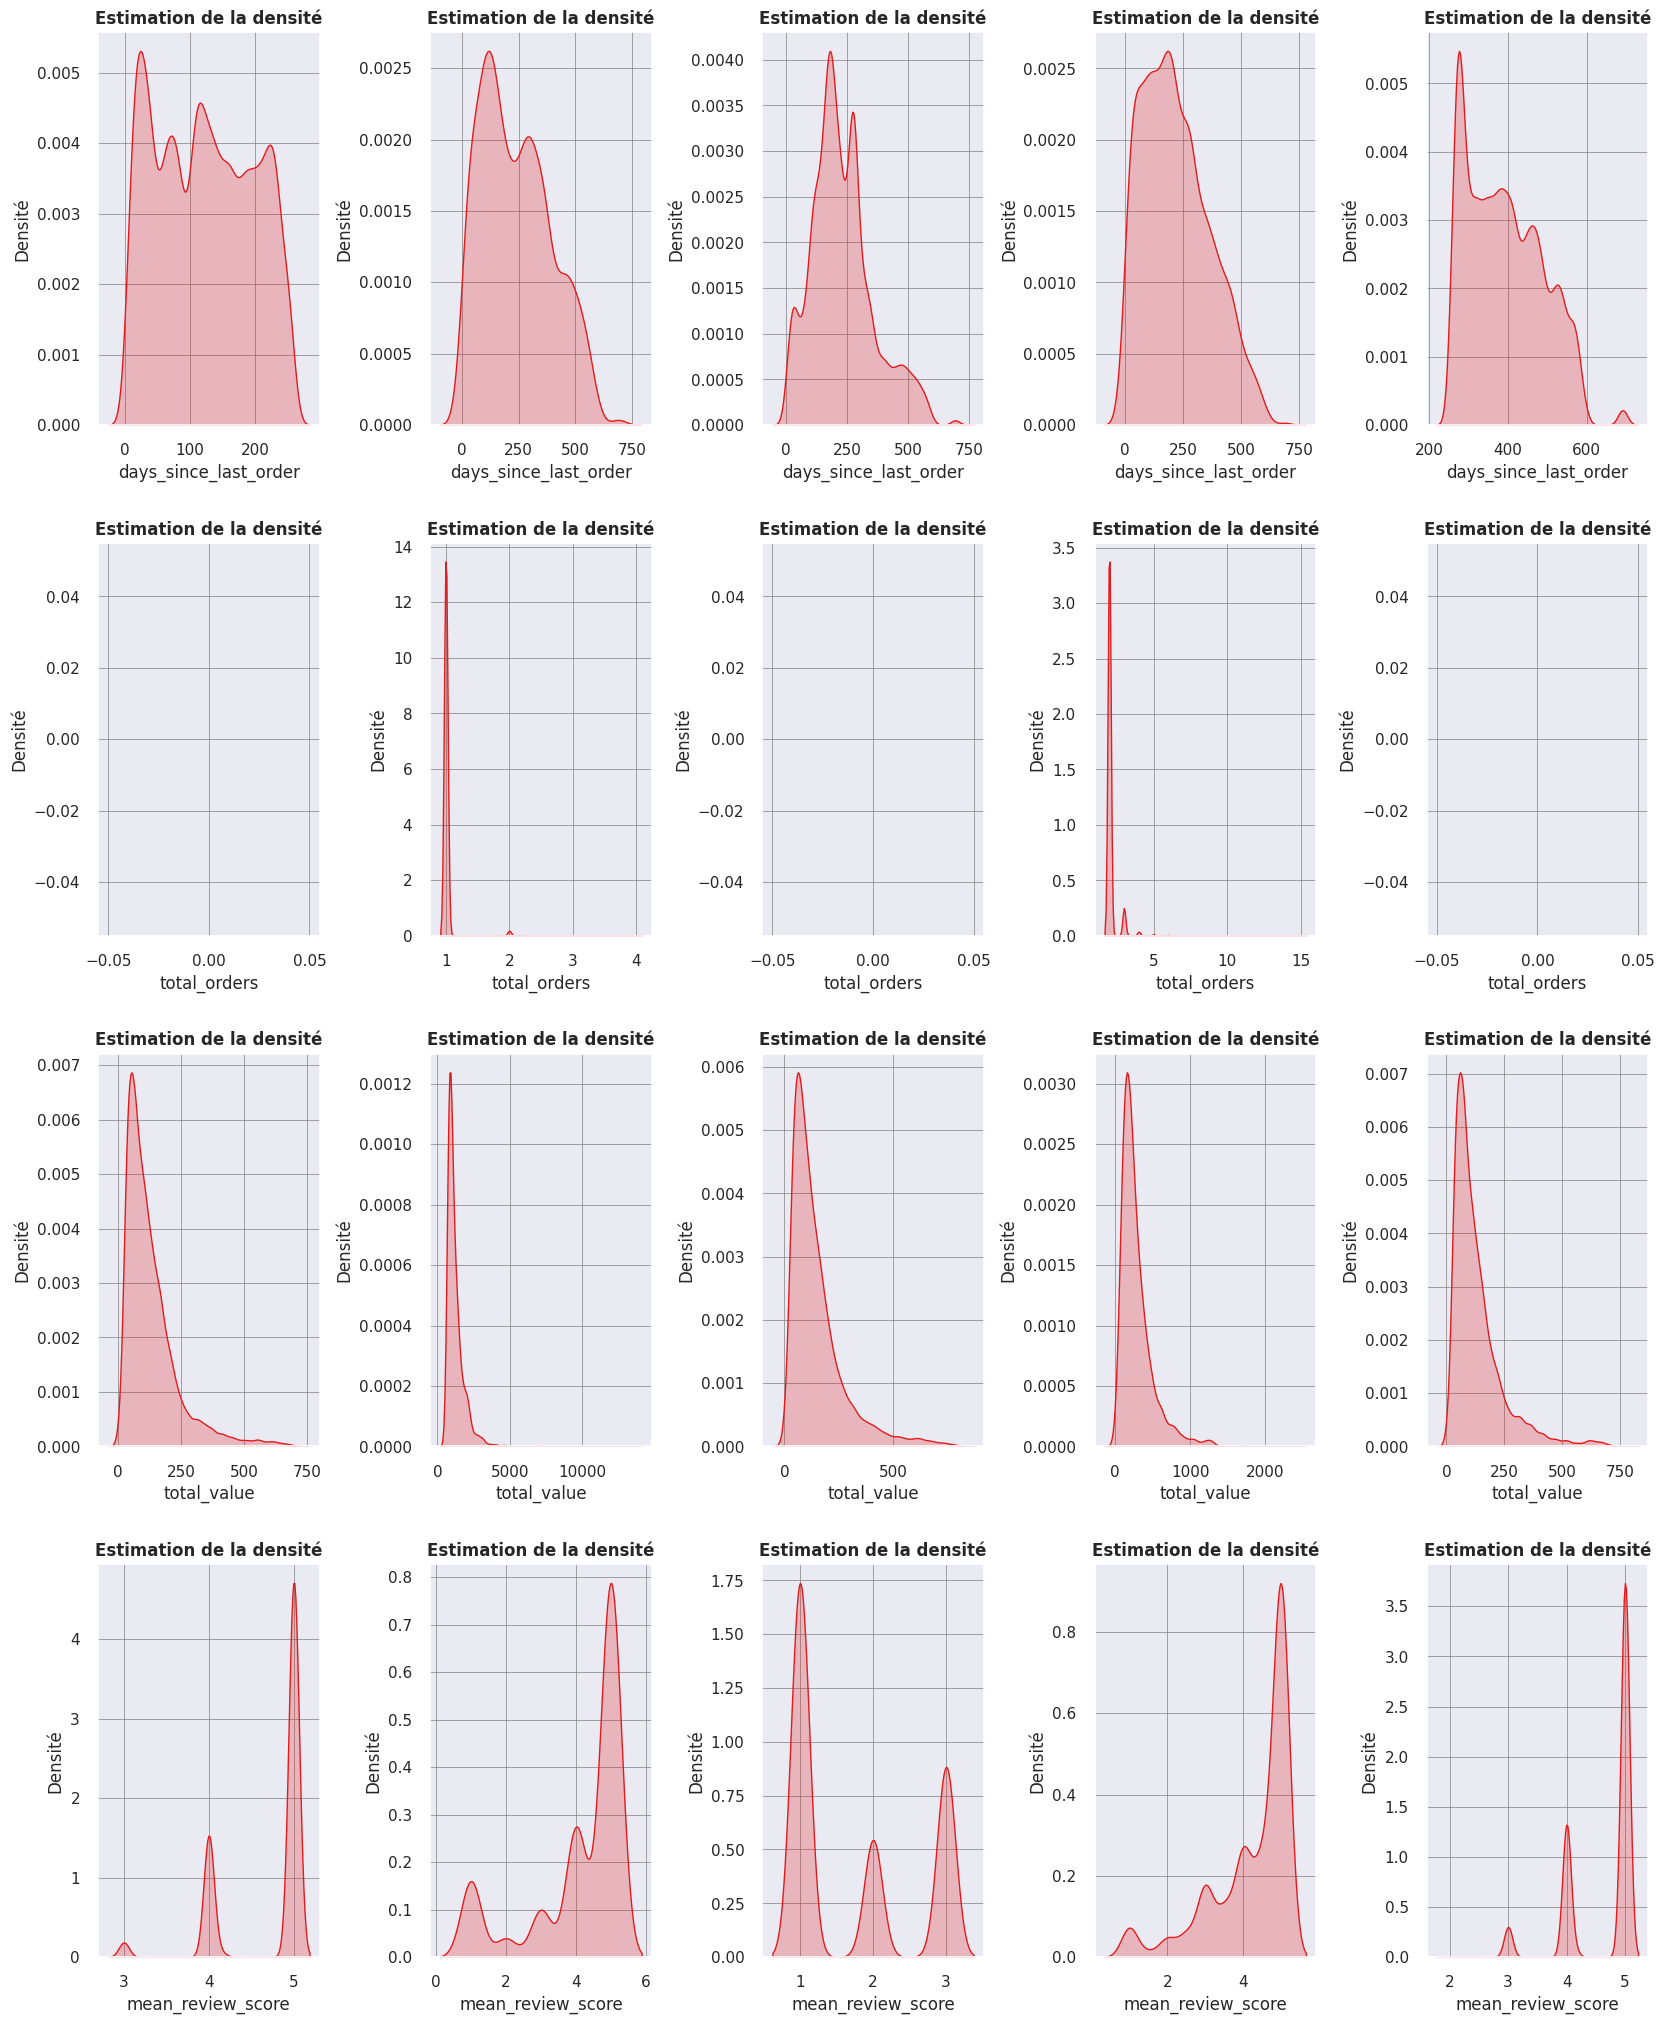

In [41]:
# Configure the grid for plots
plt.figure(figsize = (20, 25))
grid = plt.GridSpec(4, 5, wspace=0.5, hspace=0.3)

# days_since_last_order
# Density estimation cluster 1 
plt.subplot(grid[0,0])
sns.kdeplot(data=cluster_1["days_since_last_order"], fill=True)
plt.title("Estimation de la densité", fontweight="bold")
plt.xlabel("days_since_last_order")
plt.ylabel("Densité")
plt.grid(color="gray", linestyle="-", linewidth=0.5)
    
# Density estimation cluster 2 
plt.subplot(grid[0,1])
sns.kdeplot(data=cluster_2["days_since_last_order"], fill=True)
plt.title("Estimation de la densité", fontweight="bold")
plt.xlabel("days_since_last_order")
plt.ylabel("Densité")
plt.grid(color="gray", linestyle="-", linewidth=0.5)
    
# Density estimation cluster 3 
plt.subplot(grid[0,2])
sns.kdeplot(data=cluster_3["days_since_last_order"], fill=True)
plt.title("Estimation de la densité", fontweight="bold")
plt.xlabel("days_since_last_order")
plt.ylabel("Densité")
plt.grid(color="gray", linestyle="-", linewidth=0.5)

# Density estimation cluster 4 
plt.subplot(grid[0,3])
sns.kdeplot(data=cluster_4["days_since_last_order"], fill=True)
plt.title("Estimation de la densité", fontweight="bold")
plt.xlabel("days_since_last_order")
plt.ylabel("Densité")
plt.grid(color="gray", linestyle="-", linewidth=0.5)

# Density estimation cluster 5 
plt.subplot(grid[0,4])
sns.kdeplot(data=cluster_5["days_since_last_order"], fill=True)
plt.title("Estimation de la densité", fontweight="bold")
plt.xlabel("days_since_last_order")
plt.ylabel("Densité")
plt.grid(color="gray", linestyle="-", linewidth=0.5)

# total_orders
# Density estimation cluster 1 
plt.subplot(grid[1,0])
sns.kdeplot(data=cluster_1["total_orders"], fill=True)
plt.title("Estimation de la densité", fontweight="bold")
plt.xlabel("total_orders")
plt.ylabel("Densité")
plt.grid(color="gray", linestyle="-", linewidth=0.5)
    
# Density estimation cluster 2 
plt.subplot(grid[1,1])
sns.kdeplot(data=cluster_2["total_orders"], fill=True)
plt.title("Estimation de la densité", fontweight="bold")
plt.xlabel("total_orders")
plt.ylabel("Densité")
plt.grid(color="gray", linestyle="-", linewidth=0.5)
    
# Density estimation cluster 3 
plt.subplot(grid[1,2])
sns.kdeplot(data=cluster_3["total_orders"], fill=True)
plt.title("Estimation de la densité", fontweight="bold")
plt.xlabel("total_orders")
plt.ylabel("Densité")
plt.grid(color="gray", linestyle="-", linewidth=0.5)

# Density estimation cluster 4 
plt.subplot(grid[1,3])
sns.kdeplot(data=cluster_4["total_orders"], fill=True)
plt.title("Estimation de la densité", fontweight="bold")
plt.xlabel("total_orders")
plt.ylabel("Densité")
plt.grid(color="gray", linestyle="-", linewidth=0.5)

# Density estimation cluster 5 
plt.subplot(grid[1,4])
sns.kdeplot(data=cluster_5["total_orders"], fill=True)
plt.title("Estimation de la densité", fontweight="bold")
plt.xlabel("total_orders")
plt.ylabel("Densité")
plt.grid(color="gray", linestyle="-", linewidth=0.5)

# total_value
# Density estimation cluster 1 
plt.subplot(grid[2,0])
sns.kdeplot(data=cluster_1["total_value"], fill=True)
plt.title("Estimation de la densité", fontweight="bold")
plt.xlabel("total_value")
plt.ylabel("Densité")
plt.grid(color="gray", linestyle="-", linewidth=0.5)
    
# Density estimation cluster 2 
plt.subplot(grid[2,1])
sns.kdeplot(data=cluster_2["total_value"], fill=True)
plt.title("Estimation de la densité", fontweight="bold")
plt.xlabel("total_value")
plt.ylabel("Densité")
plt.grid(color="gray", linestyle="-", linewidth=0.5)
    
# Density estimation cluster 3 
plt.subplot(grid[2,2])
sns.kdeplot(data=cluster_3["total_value"], fill=True)
plt.title("Estimation de la densité", fontweight="bold")
plt.xlabel("total_value")
plt.ylabel("Densité")
plt.grid(color="gray", linestyle="-", linewidth=0.5)

# Density estimation cluster 4 
plt.subplot(grid[2,3])
sns.kdeplot(data=cluster_4["total_value"], fill=True)
plt.title("Estimation de la densité", fontweight="bold")
plt.xlabel("total_value")
plt.ylabel("Densité")
plt.grid(color="gray", linestyle="-", linewidth=0.5)

# Density estimation cluster 5 
plt.subplot(grid[2,4])
sns.kdeplot(data=cluster_5["total_value"], fill=True)
plt.title("Estimation de la densité", fontweight="bold")
plt.xlabel("total_value")
plt.ylabel("Densité")
plt.grid(color="gray", linestyle="-", linewidth=0.5)

# mean_review_score
# Density estimation cluster 1 
plt.subplot(grid[3,0])
sns.kdeplot(data=cluster_1["mean_review_score"], fill=True)
plt.title("Estimation de la densité", fontweight="bold")
plt.xlabel("mean_review_score")
plt.ylabel("Densité")
plt.grid(color="gray", linestyle="-", linewidth=0.5)
    
# Density estimation cluster 2 
plt.subplot(grid[3,1])
sns.kdeplot(data=cluster_2["mean_review_score"], fill=True)
plt.title("Estimation de la densité", fontweight="bold")
plt.xlabel("mean_review_score")
plt.ylabel("Densité")
plt.grid(color="gray", linestyle="-", linewidth=0.5)
    
# Density estimation cluster 3 
plt.subplot(grid[3,2])
sns.kdeplot(data=cluster_3["mean_review_score"], fill=True)
plt.title("Estimation de la densité", fontweight="bold")
plt.xlabel("mean_review_score")
plt.ylabel("Densité")
plt.grid(color="gray", linestyle="-", linewidth=0.5)

# Density estimation cluster 4 
plt.subplot(grid[3,3])
sns.kdeplot(data=cluster_4["mean_review_score"], fill=True)
plt.title("Estimation de la densité", fontweight="bold")
plt.xlabel("mean_review_score")
plt.ylabel("Densité")
plt.grid(color="gray", linestyle="-", linewidth=0.5)

# Density estimation cluster 5 
plt.subplot(grid[3,4])
sns.kdeplot(data=cluster_5["mean_review_score"], fill=True)
plt.title("Estimation de la densité", fontweight="bold")
plt.xlabel("mean_review_score")
plt.ylabel("Densité")
plt.grid(color="gray", linestyle="-", linewidth=0.5)

On constate tout d'abord, d'après les warnings reçus à l'exécution, que les clusters 1, 2 et 4 ont une variance de 0, ce qui signifie que tous les clients des ces clusters ont le même nombre de commandes, affichons le :

In [42]:
print(f"Nombre de commandes du cluster 1 : {cluster_1["total_orders"].mean()}")
print(f"Nombre de commandes du cluster 3 : {cluster_3["total_orders"].mean()}")
print(f"Nombre de commandes du cluster 5 : {cluster_5["total_orders"].mean()}")

Nombre de commandes du cluster 1 : 1.0
Nombre de commandes du cluster 3 : 1.0
Nombre de commandes du cluster 5 : 1.0


Ainsi, nous pouvons catégoriser nos clients comme suit :
- **Premier cluster** : clients récents, faible fréquence et montant mais satisfaits => **clients potentiels**
- **Deuxième cluster** : clients moins récents, actifs, avec un montant élevé et satisfaits => **champions**
- **Troisième cluster** : clients moins récents, faible fréquence et montant mais non satisfaits => **clients perdus**
- **Quatrième cluster** : clients moins récents, actifs, avec un montant moyen et plutôt satisfaits => **clients fièles**
- **Cinquième cluster** : clients peu récents, faible fréquence et montant mais satisfaits => **clients en déclin**

# Dendogram

Nous allons à présent utiliser un dendrogramme afin de qualifier nos clients. Pour cela, et fort de nos constats précédents, nous utiliserons les 4 variables de la segmentation RFM.

L'algorythme nécessitant beaucoup de puissance de calculs, nous allons sélectionner un échantillon de nos données.

In [11]:
rfm_sampled = pd.DataFrame(rfm_4var_scaled, columns=rfm_features).sample(n=10000, random_state=8)

In [14]:
agglo_clust = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(rfm_sampled)

In [15]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

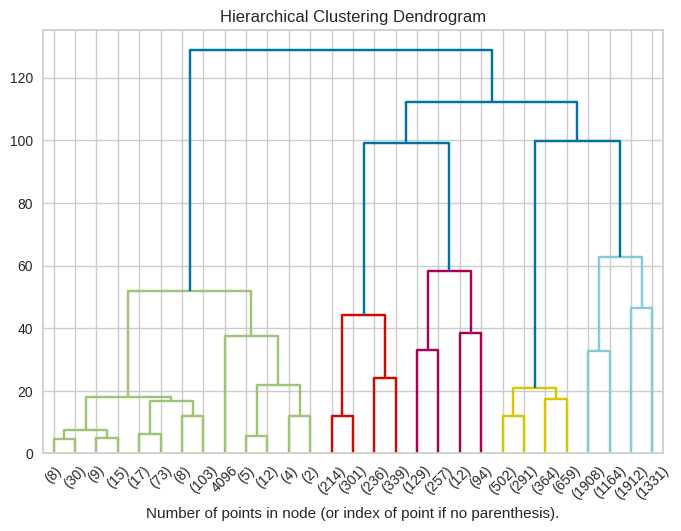

In [21]:
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(agglo_clust, truncate_mode="level", p=4)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

# DBScan

In [10]:
rfm_4var_scaled

array([[-0.82535715, -0.1598294 , -0.0919173 ,  0.66306953],
       [-0.80569671, -0.1598294 , -0.60419675, -0.12040464],
       [ 1.95987274, -0.1598294 , -0.3405767 , -0.90387882],
       ...,
       [ 2.16303069, -0.1598294 , -0.22339239,  0.66306953],
       [-0.77948278, -0.1598294 , -0.12858206,  0.66306953],
       [ 1.61253819, -0.1598294 , -0.40604629,  0.66306953]])